## Converting to Supergalactic Coordinates ##

we describe how we convert from RA, DEC, and redshift to SGX,SGY, and SGZ.

We try to reproduce the figures shown in Kim+2016

### load modules ###

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import os
import sys
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from mpl_toolkits.mplot3d import Axes3D
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import c
%matplotlib inline

/Users/kellywhalen/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Read in NSA catalog ###

In [2]:
#Get current path so program can tell if this is being run on Kelly's or Rose's computer
mypath=os.getcwd()
if mypath.find('rfinn') > -1:
    print "Running on Rose's computer"
    #agcfile='/Users/rfinn/idl/programs/idl_alfa/agctotal.sav'
    gitpath='/Users/rfinn/github/'
elif mypath.find('kelly') > -1:
    print "Running on Kellys's computer"
    gitpath='/Users/kellywhalen/Github/'


#### READ IN DATA #####

#NSA Table
NSA_file = gitpath+'Virgo/nsa_v0_1_2.fits'
#NSA_file='/Users/rfinn/research/nsa/nsa_v0_1_2.fits'
nsa = fits.getdata(NSA_file)
nsadict=dict((a,b) for a,b in zip(nsa.NSAID,np.arange(len(nsa.NSAID))))

Running on Kellys's computer


### Select Galaxies in the vicinity of Virgo ###

In [3]:
raflag = (nsa.RA > 115.) & (nsa.RA < 240.)
decflag= (nsa.DEC > -30.) & (nsa.DEC < 60.)
velflag =  (nsa.Z*3.e5 < 3000.) # & (nsa.Z*3.e5 > 1000.) 
vflag = raflag & decflag & velflag 

#nsa = nsa[vflag]

# define nsa RA and Dec as SkyCoord
nsa_sc = SkyCoord(nsa.RA*u.degree, nsa.DEC*u.degree)


##  FLOW MODEL  ##

convert RA and DEC to galactic
* l = galcoords.l.degree
* b = galcoords.b.degree



using mould+00 method to correct redshifts described in detail in appendix A

http://adsabs.harvard.edu/abs/2000ApJ...529..786M


### 1. Correct to centroid of the Local Group ###

In [4]:
# convert helio-centric velocity to units of km/s
V_H = nsa.Z*c.to('km/s')

# 1. correction of observed heliocentric velocity to centroid of local group
# VLG = VH - 79 cos l cos b + 296 sin l cos b - 36 sin b

V_LG = - 79.*u.km/u.second*np.cos(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) + 296.*u.km/u.second*np.sin(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) - 36.*u.km/u.second*np.sin(nsa_sc.galactic.b.radian)


### 2. Correction for Virgo infall

In [5]:
# from Mould+2000, ApJ, 529, 786
# not sure if we are using this equation exactly right

V_fid = 200.*u.km/u.second # infall of LG into Virgo?
# Virgo coordinates given by Mould+2000
Virgo = SkyCoord('12h28m19s', '+12d40m00s', frame='fk5',equinox='J1950.') # epoch = 1950
Virgo = Virgo.transform_to(FK5(equinox='J2000'))
### need to fix this to use spherical distance
#theta = np.sqrt((nsa_sc.ra.radian - Virgo.ra.radian)**2 + (nsa_sc.dec.radian - Virgo.dec.radian)**2)
theta = Virgo.separation(nsa_sc).radian 
# cluster radius in deg
gamma = 2.

V_a = 1035.*u.km/u.second # recession vel of Virgo from Mould+2000
#V_a = 1221.*u.km/u.second # recession vel of Virgo as calculated by Gianluca
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_infall = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))

### 3. Correction for GA infall ###

In [6]:
V_fid = 400.*u.km/u.second # infall of LG into Virgo?
# GA coordinates given by Mould+2000
GA = SkyCoord('13h20m00s', '+44d00m00s', frame='fk5',equinox='J1950.') # epoch = 1950
GA = GA.transform_to(FK5(equinox='J2000'))
theta = GA.separation(nsa_sc).radian
#theta = np.sqrt((nsa_sc.ra.radian - GA.ra.radian)**2 + (nsa_sc.dec.radian - GA.dec.radian)**2)

gamma = 2.
V_a = 4380.*u.km/u.second # recession vel of Great Attractor from Mould+2000
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_GA = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))

### 4. Correction for Shapley supercluster infall. ###

In [7]:
# Final, correction cosmic velocity is
#
#  Vcosmic = VH + Vc,LG + Vin,Virgo + Vin,GA + Vin,Shap + ...

# ## Tranforming to Supergalactic Coordinates##
# 
# Looking to match the plots shown in Kim+2016
# 
# https://arxiv.org/abs/1611.00437

### Add up all of the corrections ###

In [8]:
#Plot of Virgo Cluster in galactic coordinates
V_cosmic = V_H + V_LG + V_infall +V_GA
V = V_cosmic

### Convert to Supergalactic X, Y, and X coordinates###

In [9]:
#SGX = V/cosmo.H(0)*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
#SGY = V/cosmo.H(0)*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
#SGZ = V/cosmo.H(0)*np.sin(nsa_sc.supergalactic.sgb.radian)


# using H0 = 74 to match Kim+2016 paper
#H0 = 74.*u.km/u.second/u.Mpc
H0 = 100.*u.km/u.second/u.Mpc #Kim's email
SGX = V/H0*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGY = V/H0*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGZ = V/H0*np.sin(nsa_sc.supergalactic.sgb.radian)

### Subtract the Position of Virgo ###

In [10]:
distance_to_virgo = 16.5*u.Mpc #Mpc
SGX_Virgo = distance_to_virgo*np.cos(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGY_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGZ_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgb.radian)

# difference 
DSGX = SGX - SGX_Virgo
DSGY = SGY - SGY_Virgo
DSGZ = SGZ - SGZ_Virgo


### Various cuts used by Kim+2016 ###

In [11]:
# don't use objects w/in 3.6 Mpc of Virgo (Kim+2016)

dist = np.sqrt(DSGX**2 + DSGY**2 + DSGZ**2) 
dist_flag = dist.value > 3.6


# In[7]:

kim_vflag = nsa.Z*3.e5 < 6000.  
kim_raflag = (nsa.RA > 115.) & (nsa.RA < 240.)
kim_decflag = (nsa.DEC > -35.) & (nsa.DEC < 60.)
kim_flag = kim_vflag & kim_raflag & kim_decflag & dist_flag 

d_split = 16.
#In front of cluster
SGYfront_flag = (SGY > 4. * u.Mpc) & (SGY < d_split * u.Mpc)
SGYback_flag = (SGY > d_split * u.Mpc) & (SGY < 40. * u.Mpc)
#SGYback_flag = (SGY > 21. * u.Mpc) & (SGY < 27. * u.Mpc)

SGYvirgo =  (SGY > 4.*u.Mpc) & (SGY < d_split*u.Mpc)

In [12]:
print sum(dist_flag), len(dist_flag)

145130 145155


(array([   10.,   430.,   758.,  1171.,  1547.,  1028.,   666.,   609.,
          512.,   518.,   558.,   613.]),
 array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36]),
 <a list of 12 Patch objects>)

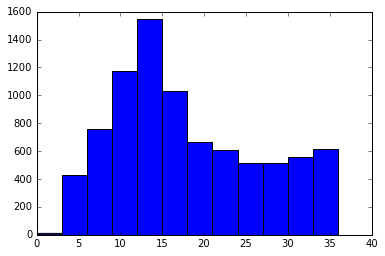

In [13]:
plt.figure()
plt.hist(dist,bins=np.arange(0,39,3))

## Making Plots ##

In [14]:
def plotxzplane(flag1, flag2):
    '''
    flag1 = things around virgo
    flag2 = things behind virgo
    '''
    plt.figure(figsize=(6,4))
    plt.scatter(SGX[flag1],SGZ[flag1],alpha=.5,c=SGY[flag1],vmin=0,vmax=36)
    #plt.scatter(DSGX,DSGZ,alpha=.5,c=DSGY)
    plt.colorbar(fraction=.08,label='SGY (Mpc)')
    plt.subplots_adjust(bottom=.15)
    #plt.axis([-15,10,-10,20])
    plt.xlabel('$SGX \ (Mpc)$')
    plt.ylabel('$SGZ \ (Mpc)$')
    plt.title('Region around Virgo Cluster (Compare to Kim Fig 2)')
    plt.axis([-15,18,-17,12])
    plt.axvline(x=0,ls='--',color='k')
    plt.axhline(y=0,ls='--',color='k')

    ## plt.figure(figsize=(6,4))
    ## plt.scatter(SGX[kim_flag & SGYfront_flag],SGZ[kim_flag & SGYfront_flag],alpha=.5,c=SGY[kim_flag & SGYfront_flag])
    ## plt.colorbar(fraction=.08)
    ## plt.axis([-15,10,-10,20])
    ## plt.xlabel('SGX (Mpc)')
    ## plt.ylabel('SGZ (Mpc)')
    ## plt.title('Region In Front of Virgo Cluster')
    ## plt.axvline(x=0,ls='--',color='k')
    ## plt.axhline(y=0,ls='--',color='k')

    plt.figure(figsize=(6,4))
    plt.subplots_adjust(bottom=.15)
    plt.scatter(SGX[flag2],SGZ[flag2],alpha=.5,c=SGY[flag2],vmin=0,vmax=36)
    #plt.scatter(SGX[NGCfilament],SGZ[NGCfilament],alpha=1,c=SGY[NGCfilament],s=60)
    plt.colorbar(fraction=.08,label='SGY (Mpc)')
    plt.axis([-15,10,-10,20])
    plt.xlabel('$SGX \ (Mpc)$')
    plt.ylabel('$SGZ \ (Mpc)$')
    plt.title('Region Behind Virgo Cluster (Compare to Kim Fig 3)')
    plt.axvline(x=0,ls='--',color='k')
    plt.axhline(y=0,ls='--',color='k')
    plt.axis([-18,7,-10,14])


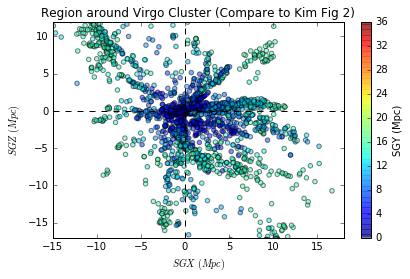

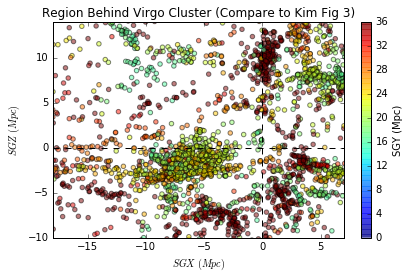

In [15]:
flag1 = kim_flag = kim_vflag & kim_raflag & kim_decflag & dist_flag & (SGY < 16.*u.Mpc)& (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > 16.*u.Mpc)
plotxzplane(flag1,flag2)

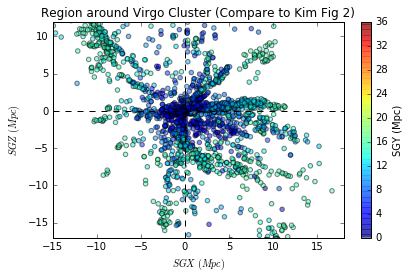

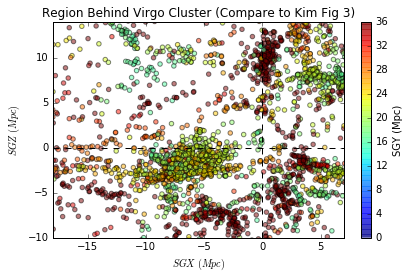

In [16]:
flag1 = kim_flag = kim_vflag  & kim_decflag & dist_flag & (SGY < 16.*u.Mpc) & (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > 16.*u.Mpc)
plotxzplane(flag1,flag2)

## RA and DEC cuts don't affect the plots
## the SGY cut does affect the plot

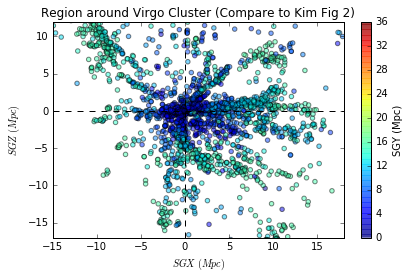

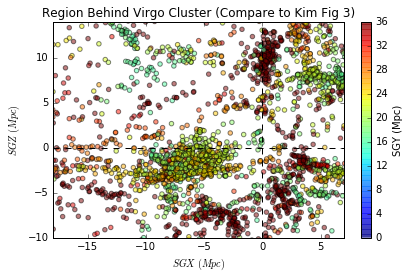

In [17]:
flag1 = kim_flag = kim_vflag & dist_flag & (SGY < 16.*u.Mpc) & (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > 16.*u.Mpc)
plotxzplane(flag1,flag2)

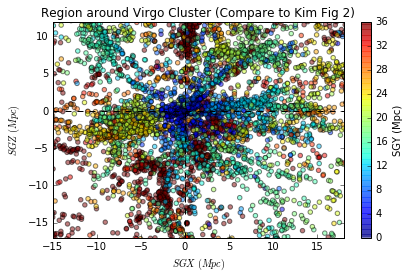

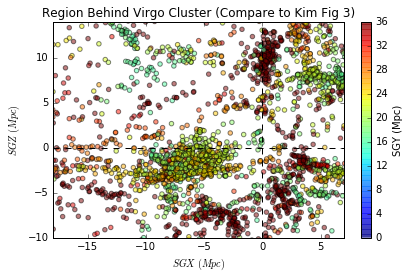

In [18]:
flag1 = kim_flag = kim_vflag & dist_flag & (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > 16.*u.Mpc)
plotxzplane(flag1,flag2)

## We are not using the SGY cut on the first plot.
## all of the extra points are from things in front of or behind Virgo

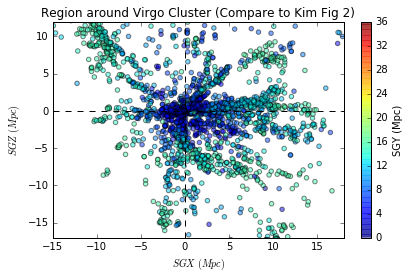

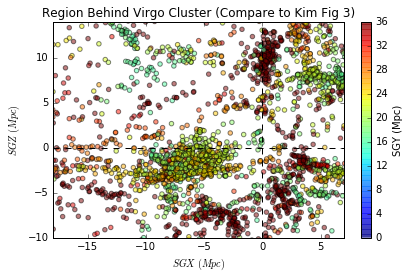

In [19]:
flag1 = kim_flag = kim_vflag  & (SGY < 16.*u.Mpc) & (SGY > 0.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > 16.*u.Mpc)
plotxzplane(flag1,flag2)

## 16 Mpc cut is removing lots of stuff on lower left quadrant
## indicates that our SGY values are off from Kim+2016 values
## going to try adjusting the 16 Mpc cut

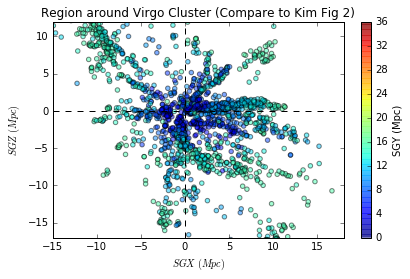

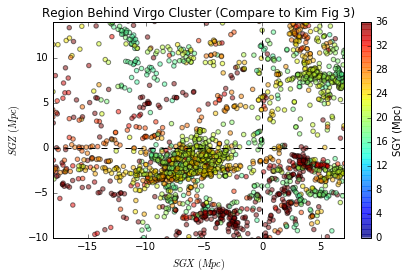

In [20]:
SGY_cut = 16.
flag1 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY < SGY_cut*u.Mpc) & (SGY > 4.*u.Mpc)
flag2 = kim_flag = kim_vflag & kim_raflag & kim_decflag & (SGY > SGY_cut*u.Mpc) & (SGY < 45*u.Mpc)
plotxzplane(flag1,flag2)


In [21]:
# the dictionary will return the index for a galaxy with the matching NSAID
# for example, for NGC 5353

print 'NGC 5353'
print 'index = ',nsadict[56483]

# to get its recession velocity
print 'recession velocity = ',nsa.Z[nsadict[56483]]*3.e5

# to get its SGYY
print 'SGY = ',SGY[nsadict[56483]]

print ' '

print 'NGC 5354'
print 'index = ',nsadict[144021]

# to get its recession velocity
print 'recession velocity = ',nsa.Z[nsadict[144021]]*3.e5

# to get its SGY
print 'SGY = ',SGY[nsadict[144021]]

NGC 5353
index =  50826
recession velocity =  2365.47142267
SGY =  20.620614387 Mpc
 
NGC 5354
index =  128813
recession velocity =  2598.80181402
SGY =  21.7417267387 Mpc


In [22]:
# NED SGY Values for NGC 5353/4
SGY5353 = 2895. *(u.km/u.s)/H0*np.sin(78.7400669 * np.pi / 180.)*np.cos(21.1159630* np.pi / 180.) #Got V from NED
SGY5354 = 3148. *(u.km/u.s)/H0*np.sin(78.7400669 * np.pi / 180.)*np.cos(21.1170420 * np.pi / 180.) #Got V from NED

print 'NED SGY for NGC 5353: ', SGY5353
print 'NED SGY for NGC 5354: ', SGY5354

NED SGY for NGC 5353:  26.4862717319 Mpc
NED SGY for NGC 5354:  28.8007519882 Mpc


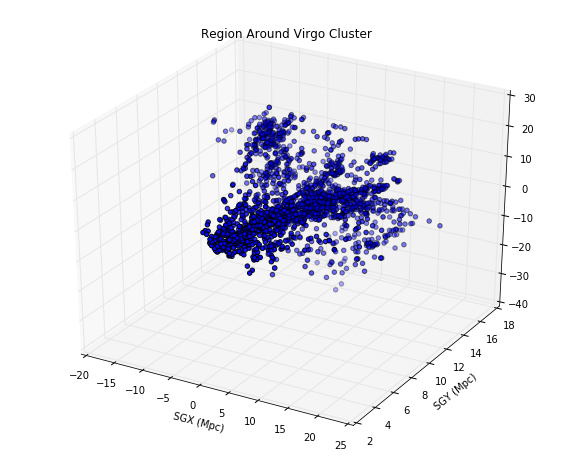

In [23]:
#3D Plot
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(SGX[kim_vflag & kim_raflag & kim_decflag & (SGY < SGY_cut*u.Mpc) & (SGY > 4.*u.Mpc)], SGY[kim_vflag & kim_raflag & kim_decflag & (SGY < SGY_cut*u.Mpc) & (SGY > 4.*u.Mpc)], SGZ[kim_vflag & kim_raflag & kim_decflag & (SGY < SGY_cut*u.Mpc) & (SGY > 4.*u.Mpc)])
plt.title('Region Around Virgo Cluster')
plt.xlabel('SGX (Mpc)')
plt.ylabel('SGY (Mpc)')
#plt.zlabel('SGZ (Mpc)')


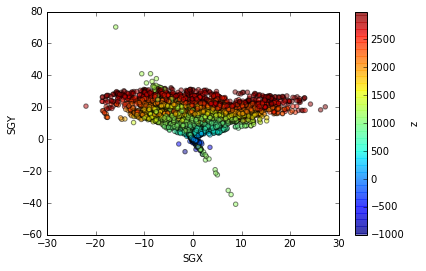

In [24]:
#See where virgo lies in SGX-SGY plane
plt.figure()
plt.scatter(SGX[vflag],SGY[vflag],alpha=.5,c=nsa.Z[vflag] * 3.e5)
plt.colorbar(fraction=.08,label='z')
plt.xlabel('SGX')
plt.ylabel('SGY')